# Определение возраста покупателей 
## Описание проекта

1. Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя.


2. Исследовательский анализ данных - загруза библиотек, датасета, фотографий. Определение распределение выборки по возрасту. Оценка фотографий в выборке.

3. Обучение модели - постройка архетиктуры нейроной модели, её обучение, рассмотрение результатов обучения.
4. Анализ обученной модели - выводы .   

## Исследовательский анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras import metrics
from PIL import Image

In [2]:
# загрузка целевого признака
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

In [4]:
# загрузка признаков
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


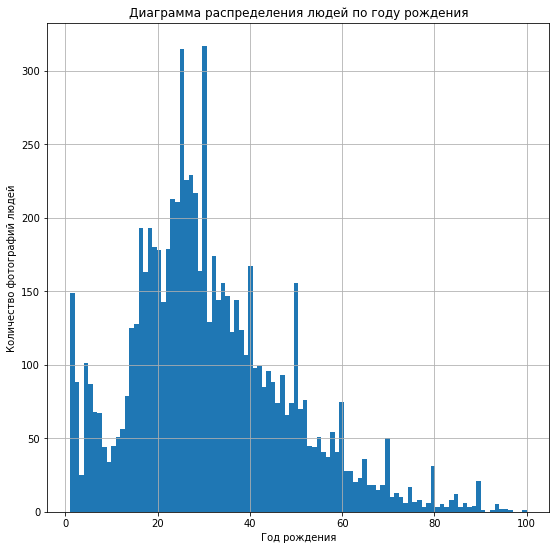

In [5]:
# построим график, что бы посмотреть как возраст людей распределён в выборке
labels['real_age'].hist(bins=100, figsize=(9, 9));
plt.title('Диаграмма распределения людей по году рождения')
plt.xlabel('Год рождения')
plt.ylabel('Количество фотографий людей')
plt.show()

Вывод: выборка подобрана таким образом, чтобы эмитировать нормальное распределение людей разного возраста в социуме. Больше всего людей в  возрасте от 18 до 50 лет. Детей и предпенсионеров среднее количество. Пенсионеров меньше всего. 

In [6]:
# формируем случайный батч
batch = next(train_gen_flow) 

<Figure size 1440x1440 with 0 Axes>

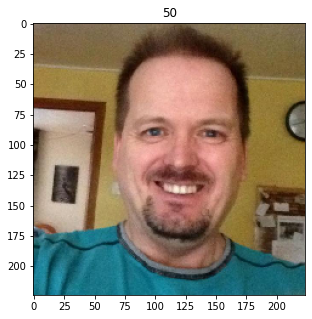

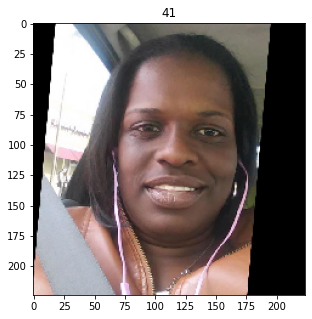

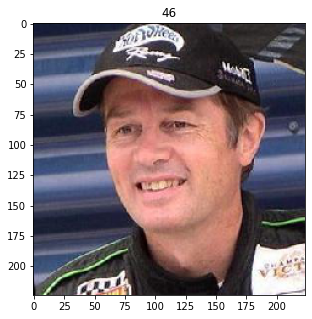

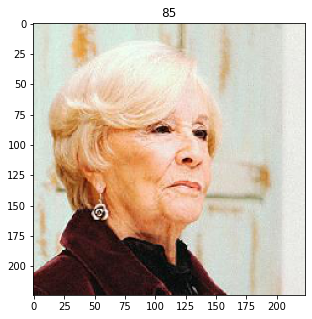

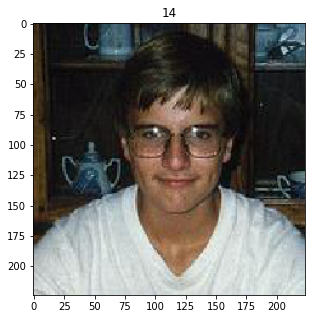

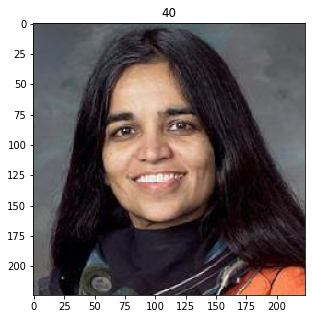

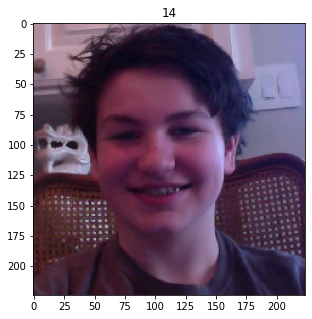

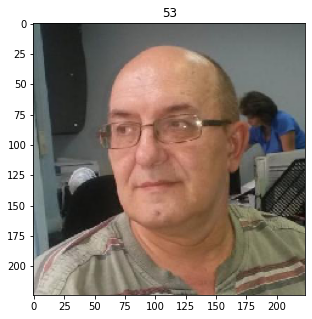

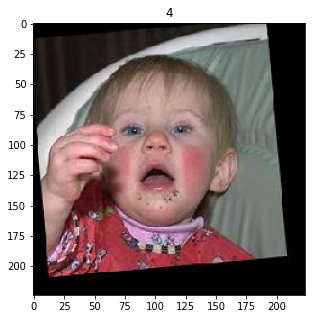

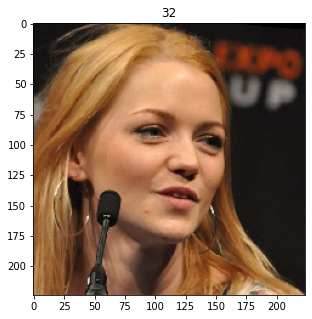

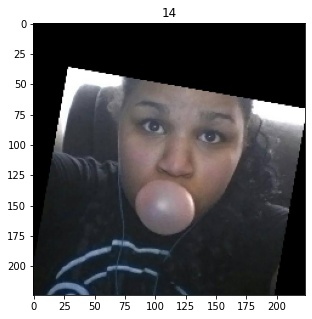

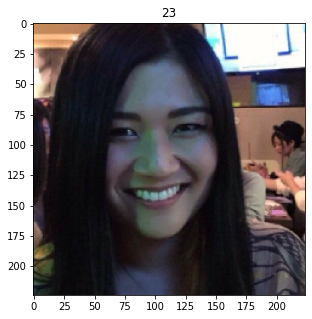

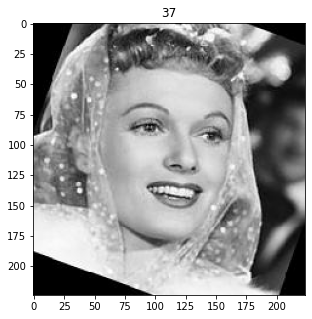

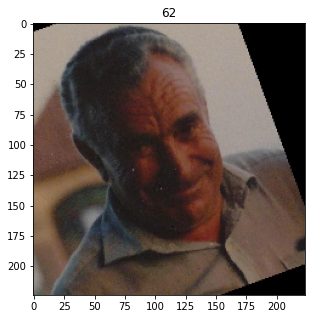

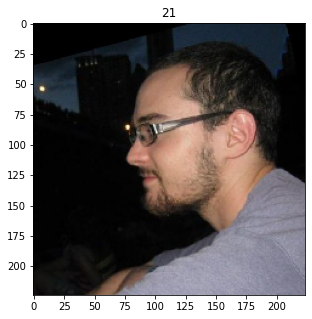

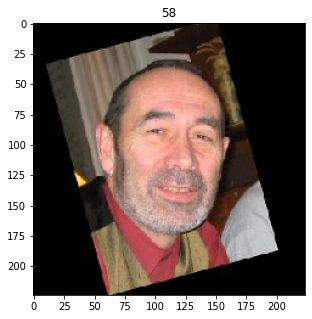

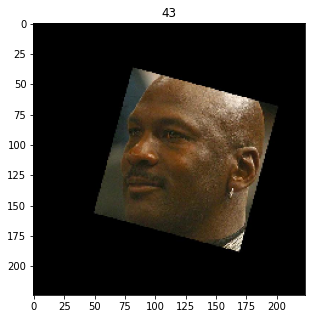

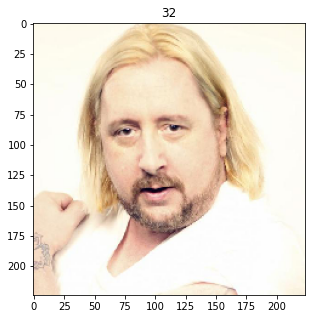

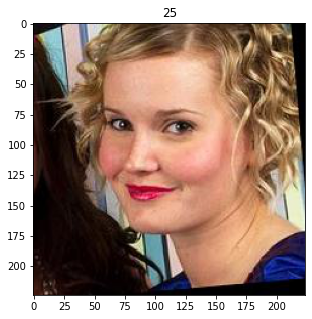

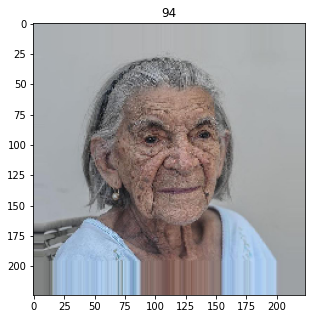

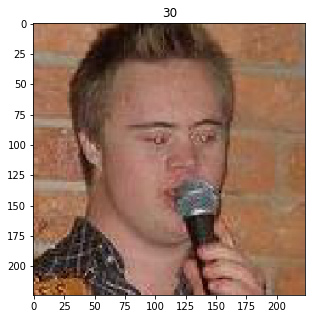

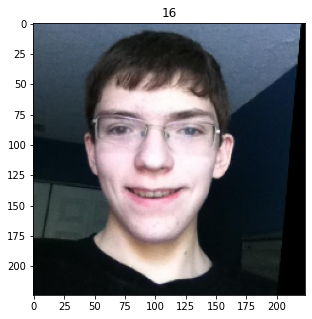

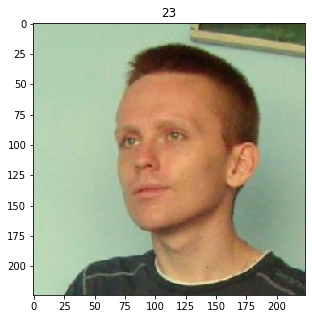

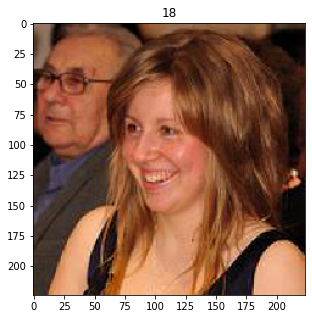

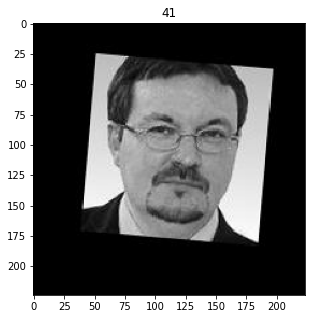

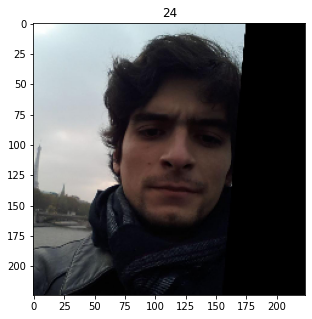

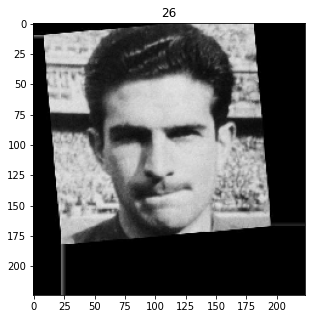

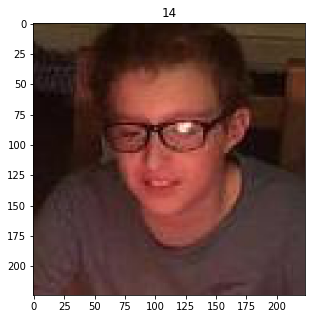

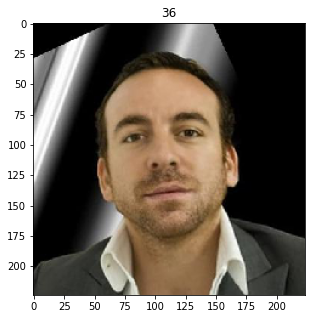

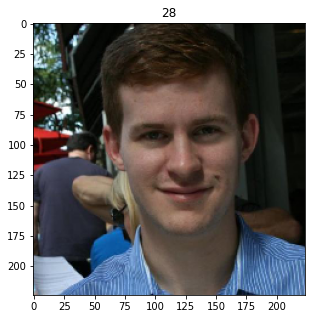

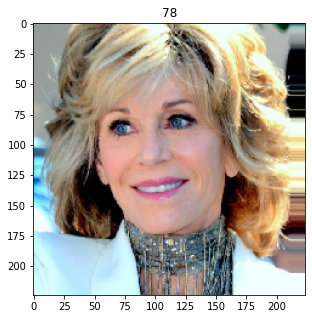

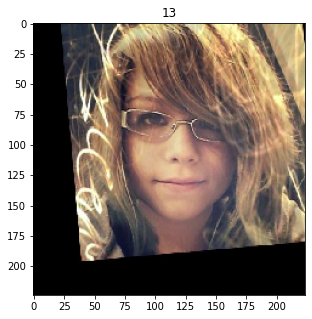

In [7]:
# строим графики изображений
plt.figure(figsize=(20, 20))
for i in range(32):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(batch[0][i]))
    plt.title(batch[1][i])
    plt.show()

Выводы: в выборке присуствуют как чёрно-белые, так и цветные. У некоторых фотографий присутствует повороты и уменьшение размера. Эти факторы могут негативно сказаться на обучение модели. 

## Обучение модели

In [8]:
# функция для загрузки обучающей выборки
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255, horizontal_flip=True)
    labels = pd.read_csv(path+'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                                       dataframe=labels,
                                                       directory=path+'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=8,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345)
    return train_datagen_flow

In [9]:
# функция для тестовой выборки
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
    labels = pd.read_csv(path+'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
                                                       dataframe=labels,
                                                       directory=path+'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=8,
                                                       class_mode='raw',
                                                       subset='validation',
                                                       seed=12345)
    return test_datagen_flow

In [10]:
# функция для построения модели
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    return model

In [11]:
# функция для обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):

    
    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

### Результат обучения модели

```

Train for 712 steps, validate for 238 steps
Epoch 1/20
2023-04-22 20:53:39.474155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-22 20:53:39.788041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
712/712 - 59s - loss: 11.7789 - mae: 11.7799 - val_loss: 14.4511 - val_mae: 14.4425
Epoch 2/20
712/712 - 50s - loss: 9.7838 - mae: 9.7845 - val_loss: 9.3304 - val_mae: 9.3143
Epoch 3/20
712/712 - 43s - loss: 8.9174 - mae: 8.9166 - val_loss: 7.8546 - val_mae: 7.8704
Epoch 4/20
712/712 - 42s - loss: 8.3774 - mae: 8.3779 - val_loss: 8.2470 - val_mae: 8.2265
Epoch 5/20
712/712 - 48s - loss: 8.0991 - mae: 8.0994 - val_loss: 7.6193 - val_mae: 7.6438
Epoch 6/20
712/712 - 49s - loss: 7.5703 - mae: 7.5711 - val_loss: 7.6184 - val_mae: 7.6027
Epoch 7/20
712/712 - 42s - loss: 7.3569 - mae: 7.3576 - val_loss: 7.0498 - val_mae: 7.0633
Epoch 8/20
712/712 - 42s - loss: 7.1393 - mae: 7.1387 - val_loss: 9.5183 - val_mae: 9.5010
Epoch 9/20
712/712 - 42s - loss: 6.7042 - mae: 6.7036 - val_loss: 7.5799 - val_mae: 7.6044
Epoch 10/20
712/712 - 41s - loss: 6.5890 - mae: 6.5897 - val_loss: 7.2350 - val_mae: 7.2486
Epoch 11/20
712/712 - 41s - loss: 6.3967 - mae: 6.3963 - val_loss: 7.4056 - val_mae: 7.4273
Epoch 12/20
712/712 - 42s - loss: 6.1593 - mae: 6.1585 - val_loss: 8.0411 - val_mae: 8.0511
Epoch 13/20
712/712 - 41s - loss: 6.1207 - mae: 6.1213 - val_loss: 7.1353 - val_mae: 7.1513
Epoch 14/20
712/712 - 41s - loss: 5.8300 - mae: 5.8302 - val_loss: 7.0814 - val_mae: 7.1052
Epoch 15/20
712/712 - 45s - loss: 5.7284 - mae: 5.7283 - val_loss: 7.8029 - val_mae: 7.8236
Epoch 16/20
712/712 - 75s - loss: 5.6297 - mae: 5.6295 - val_loss: 7.4576 - val_mae: 7.4746
Epoch 17/20
712/712 - 76s - loss: 5.4613 - mae: 5.4614 - val_loss: 6.8400 - val_mae: 6.8629
Epoch 18/20
712/712 - 73s - loss: 5.4475 - mae: 5.4471 - val_loss: 6.7528 - val_mae: 6.7727
Epoch 19/20
712/712 - 77s - loss: 5.3679 - mae: 5.3685 - val_loss: 6.6534 - val_mae: 6.6693
Epoch 20/20
712/712 - 78s - loss: 5.2036 - mae: 5.2043 - val_loss: 6.6494 - val_mae: 6.6657
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 11s - loss: 6.6494 - mae: 6.6657
Test MAE: 6.6657

```

## Анализ обученной модели

Для решения задачи классификации - определения возраста покупателя по фотографии, была выбрана архитектура свёрточной нейросети ResNet50. В сеть добавлен слой пулинга в виде GlobalAveragePooling2D, а так же скрытый полносвязаный слой на 256 нейронов. После слоя пулинга и полносвязаного слоя добавлены слои Dropout, которые дропают случайным образом 25% и 50% выборки соответственно на переходе на следующий слой, как метод борьбы с переобучением модели. В качестве фунции активации выбрана ReLu, в качестве оптимизатора - алгоритм Adam. За оценку качества обученной модели отвечает метрика MAE.

По результате обучения и тестирования модели на 20 эпохах удалось достичь отметки MAE в размере 6,6657 едениц, что удовлетворяет поставленной цели в проекте.
